<a href="https://colab.research.google.com/github/dfavenfre/MultiModal-RAG/blob/main/src/notebookMulti_Modal_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
%pip install -U --quiet langchain langchain_community openai chromadb langchain-experimental langchain-openai
%pip install --quiet "unstructured[all-docs]" pypdf pillow pydantic lxml pillow matplotlib chromadb tiktoken
%pip install --quiet PyMuPDF Pillow Spire.PDF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.6/974.6 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.4/327.4 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.5/559.5 kB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.5/202.5 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.8/321.8 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

## Imports

In [ ]:
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain.storage import InMemoryStore
from langchain_community.embeddings import VertexAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatVertexAI
from langchain_community.llms import VertexAI
from langchain_core.messages import AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableLambda
from google.colab import userdata
from IPython.display import HTML, display
from PIL import Image
from typing import Optional, Union, Dict, Tuple, List
from datetime import datetime

import base64
import os
import uuid
import io
import re
import time
import json

# Models & Prompts

In [ ]:
# CONSTANT VARIABLES
_OPENAI_EMBEDDING_MODEL = OpenAIEmbeddings(
    openai_api_key=userdata.get("<OPENAI_API_KEY>")
)

GPT_4o = ChatOpenAI(
    openai_api_key=userdata.get("<OPENAI_API_KEY>"),
    temperature=1e-10,
    max_tokens=500,
    model_name="gpt-4o"
)

rag_model = ChatOpenAI(
    openai_api_key=userdata.get("<OPENAI_API_KEY>"),
    temperature=1e-10,
    max_tokens=500,
    model_name="gpt-3.5-turbo"
)

# Helper Functions

In [ ]:
def load_and_create_document(file_path: str) -> List[str]:
  """
  Description:
  -------------
  Loads a PDF document from a given file path and
  returns a list of strings containing the text content of each page.

  Args:
    file_path: The path to the PDF file.

  Returns:
    A list of strings representing the text content of each page in the PDF document.
  """
  loader = PyPDFLoader(file_path)
  docs = loader.load()
  texts = [d.page_content for d in docs]

  return texts

In [ ]:
def generate_text_summaries(
    texts: List[str],
    tables: Optional[List] = [],
    summarize_texts: bool=True,
    model: ChatOpenAI = GPT_4o
    ):
  """
  Summarize text elements
  texts: List of str
  tables: List of str
  summarize_texts: Bool to summarize texts
  """

  # Prompt
  prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
  These summaries will be embedded and used to retrieve the raw text or table elements. \
  Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
  prompt = PromptTemplate.from_template(prompt_text)
  empty_response = RunnableLambda(
      lambda x: AIMessage(content="Error processing document")
  )

  # Text summary chain
  summarize_chain = (
      {
          "element": lambda x: x
      }
      | prompt
      | model
      | StrOutputParser()
  )

  # Initialize empty summaries
  text_summaries = []
  table_summaries = []

  # Apply to text if texts are provided and summarization is requested
  if texts and summarize_texts:
      text_summaries = summarize_chain.batch(texts, {"max_concurrency": 1})
  elif texts:
      text_summaries = texts

  # Apply to tables if tables are provided
  if tables:
    table_summaries = summarize_chain.batch(tables, {"max_concurrency": 1})

    return text_summaries, table_summaries

  else:
    return text_summaries

In [ ]:
def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

In [ ]:
def image_summarize(img_base64, prompt, model: ChatOpenAI = GPT_4o):
    """Make image summary"""
    msg = model.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{img_base64}"
                            },
                    },
                ]
            )
        ]
    )
    return msg.content

In [ ]:
def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .PNG files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []
    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".png"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries

In [ ]:
def create_chroma_vectorstore(
    collection_name: Optional[str] = "mm_rag_for_econ221",
    directory_name: Optional[str] = './chromadb'
    ) -> Chroma:
    """
    Description:
    -------------
    Creates a multi-vector store with the given retriever,
    collection name, and directory name.

    Args:
        retriever: The multi-vector retriever to use.
        collection_name: The name of the collection to create.
        directory_name: The directory to store the collection in.

    Returns:
        A Chroma object representing the multi-vector store.
    """
    vectorstore = Chroma(
    collection_name=collection_name,
    embedding_function=_OPENAI_EMBEDDING_MODEL,
    persist_directory=directory_name,
    collection_metadata={"hnsw:space":"cosine"}
    )
    vectorstore.persist()

    return vectorstore

In [ ]:
def update_documents(
    retriever: Chroma,
    doc_summaries: List[str],
    doc_contents: List[str]
    ) -> None:
    """Adds documents to a MultiVectorRetriever.

    Args:
        retriever: The chroma vectorstore instance.
        doc_summaries: A list of document summaries.
        doc_contents: A list of document contents.
    """

    doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
    summary_docs = [
        Document(page_content=s, metadata={"doc_id": doc_ids[i]})
        for i, s in enumerate(doc_summaries)
    ]
    retriever.vectorstore.add_documents(summary_docs)
    retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

In [ ]:
def create_multi_vector_retriever(
    vectorstore,
    text_summaries: List[str],
    texts: List[str],
    image_summaries,
    images,
    table_summaries: Optional[List[str]] = None,
    tables: Optional[List[str]] = None,
    ):
  """
  Create retriever that indexes summaries, but returns raw images or texts
  """

  # Initialize the storage layer
  store = InMemoryStore()
  id_key = "doc_id"

  # Create the multi-vector retriever
  retriever = MultiVectorRetriever(
      vectorstore=vectorstore,
      docstore=store,
      id_key=id_key,
  )

  # Check that text_summaries is not empty before adding
  if text_summaries:
      update_documents(retriever, text_summaries, texts)
  # Check that table_summaries is not empty before adding
  if table_summaries:
      update_documents(retriever, table_summaries, tables)
  # Check that image_summaries is not empty before adding
  if image_summaries:
      update_documents(retriever, image_summaries, images)

  return retriever

In [ ]:
def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))

In [ ]:
def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None

In [ ]:
def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False

In [ ]:
def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

In [ ]:
def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    if len(b64_images) > 0:
        return {"images": b64_images[:1], "texts": []}
    return {"images": b64_images, "texts": texts}

In [ ]:
def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
        "You are a teaching assistant helping students of TED University to guide them in questions\n"
        "related to their macroeconomics 221 course.\n"
        "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
        "Use this information to to answer questions related to their macroeconomics 221 lecture and topics related to the course. \n"
        "Provide concise and to-the-point answers.\n"
        f"User-provided question: {data_dict['question']}\n\n"
        "Text and / or tables:\n"
        f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)
    return [HumanMessage(content=messages)]

In [ ]:
def multi_modal_rag_chain(retriever, model: ChatOpenAI = GPT_4o):
    """
    Multi-modal RAG chain
    """
    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain

In [ ]:
def save_content(texts, text_summaries, img_base64_list, image_summaries, filename):
    data = {
        "texts": texts,
        "text_summaries": text_summaries,
        "img_base64_list": img_base64_list,
        "image_summaries": image_summaries
    }
    with open(filename, 'w') as f:
        json.dump(data, f)

In [ ]:
def load_tuples(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data["texts"], data["text_summaries"], data["img_base64_list"], data["image_summaries"]

# Document/Image/Table Preprocessing

In [ ]:
texts = load_and_create_document("/content/macroeconomics_chapter_1.pdf")
text_summaries = generate_text_summaries(texts)

In [ ]:
img_base64_list, image_summaries = generate_img_summaries("/content/ECON211_IMAGES")

## Save & Load created image and text summaries

In [ ]:
save_content(texts, text_summaries, img_base64_list, image_summaries, "data_summaries.json")
loaded_texts, loaded_text_summaries, loaded_img_base64_list, loaded_image_summaries = load_tuples("data_summaries.json")

# Multi-Modal Retriever & Vectorstore Generation

In [ ]:
# The vectorstore to use to index the summaries
chromadb_vectorstore = create_chroma_vectorstore(
    collection_name="mm_rag_for_econ221",
    directory_name="./chromadb"
)
# Create multi-modal retriever
mmretrieval = create_multi_vector_retriever(
    chromadb_vectorstore,
    loaded_text_summaries,
    loaded_texts,
    loaded_image_summaries,
    loaded_img_base64_list
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(


# Multi-Modal RAG

In [ ]:
chain_multimodal_rag = multi_modal_rag_chain(retriever=mmretrieval)

In [ ]:
rag_needles = [
    "Can you display the unemployment rate comparison between the united states and euro area?",
    "Show the chart where the relationship between CPI and GDP deflator used for calculating inflation rate"
]


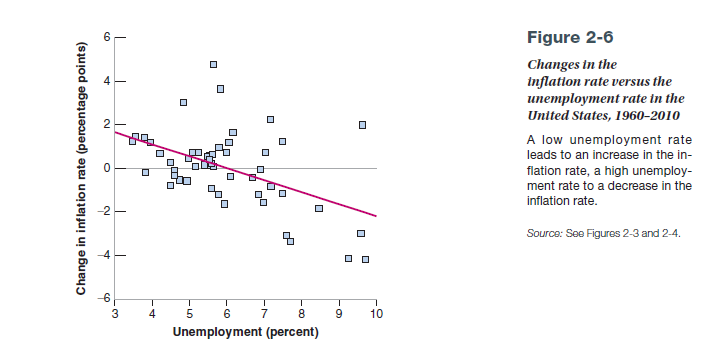

The chart provided shows the relationship between the Consumer Price Index (CPI) and the GDP deflator in calculating the inflation rate from 1960 to 2010. The inflation rates computed using either the CPI or the GDP deflator are largely similar, as indicated by the close movement of the two lines over the years. The CPI is represented by the blue line, while the GDP deflator is represented by the pink line.
-------------------------------------------

***Time Elapsed During Image and Text Retrieval: 0:00:05.817202***


In [ ]:
docs = mmretrieval.invoke(rag_needles[1], limit=1)
plt_img_base64(docs[1])
mm_rag_process_begins = datetime.now()
result = chain_multimodal_rag.invoke(rag_needles[1])
mm_rag_process_ends = datetime.now()
print(result)
print("-------------------------------------------")
print(f"\n***Time Elapsed During Image and Text Retrieval: {mm_rag_process_ends - mm_rag_process_begins}***")